In [41]:
import pandas as pd
import io
import requests
from dfply import *
import datetime
from matplotlib import pyplot as plt

In [2]:
# Reading first csv
url1 = "https://raw.githubusercontent.com/bwu99/nov2020_homework/main/data/Assignment%202%20-%20USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv"
s = requests.get(url1).content
df1 = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
# Convert Date/Time to only date and hour
temp = pd.Timedelta('1 days')
df1['hour'] = df1['Date/Time'].apply(lambda x: x.split()[0]+' '+str(int(x.split()[1][:2])-1).zfill(2))

In [4]:
# Reading second csv
url2 = "https://raw.githubusercontent.com/bwu99/nov2020_homework/main/data/Assignment%202%20-%20new.app4.csv"
s = requests.get(url2).content
df2 = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col = 0)

In [5]:
# Summing up minute by minute data to hourly data and convert W to kW
df2['hour'] = pd.to_datetime(df2['time']).dt.strftime('%m/%d %H')
year = int(pd.to_datetime(df2.iloc[0, 0]).strftime('%Y'))
df2 >>= group_by(X.hour) >> summarize(Extra = X.W_min.sum()/1000)

In [6]:
# Joining 2 datadrames
df = (df1 >> left_join(df2, by = 'hour') >> select(~X.hour)).fillna(0)

In [7]:
# Adding up columns to get total consumption
df['total_consumption'] = df.sum(axis = 1)

In [8]:
# Glimpse of the new data frame
df.head()

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),Extra,total_consumption
0,01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,0.0,11.035430
1,01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,0.0,11.496637
2,01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,0.0,11.757447
3,01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,0.0,11.885034
4,01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,0.0,12.323477


In [9]:
# Get month, day and HE
dfnew = df.copy()
dfnew['month'] = dfnew['Date/Time'].apply(lambda x: int(x.split()[0][:2]))
dfnew['day'] = dfnew['Date/Time'].apply(lambda x: int(x.split()[0][-2:]))
dfnew['HE'] = dfnew['Date/Time'].apply(lambda x: int(x.split()[1][:2]))

In [10]:
# Get weekday using month and day
def get_weekday(row):
    d = datetime.date(year, row['month'], row['day'])
    return d.strftime('%a')

In [11]:
# Get weekday and clean data
dfnew['weekday'] = dfnew.apply(lambda x: get_weekday(x), axis = 1)
dfnew = dfnew[['month', 'day', 'weekday', 'HE', 'total_consumption']]

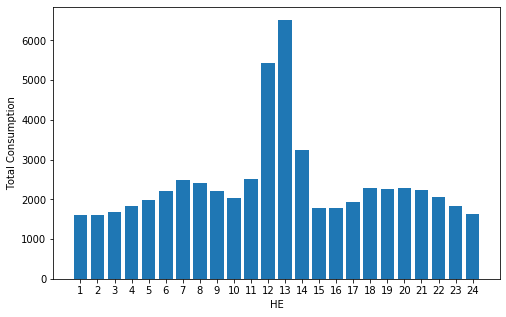

In [17]:
# Sum and plot usage by hours
dfhour = (dfnew >> group_by(X.HE) >> summarize(total_consumption = X.total_consumption.sum()) 
          >> select(X.HE, X.total_consumption))
plt.figure(figsize=(8,5))
plt.bar(dfhour['HE'], dfhour['total_consumption'])
plt.xticks(np.arange(1, 25))
plt.xlabel('HE')
plt.ylabel('Total Consumption')
plt.show()

In [31]:
# Get month, day, weekday and HE for extra consumption data
df2new = df2.copy()
df2new['month'] = df2new['hour'].apply(lambda x: int(x.split()[0][:2]))
df2new['day'] = df2new['hour'].apply(lambda x: int(x.split()[0][-2:]))
df2new['HE'] = df2new['hour'].apply(lambda x: int(x.split()[1]) + 1)
df2new['weekday'] = df2new.apply(lambda x: get_weekday(x), axis = 1)

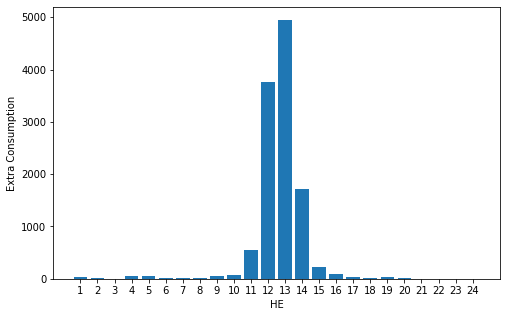

In [32]:
# Plot extra usage by hours
df2hour =  (df2new >> group_by(X.HE) >> summarize(Extra = X.Extra.sum()) >> select(X.HE, X.Extra))
plt.figure(figsize=(8,5))
plt.bar(df2hour['HE'], df2hour['Extra'])
plt.xticks(np.arange(1, 25))
plt.xlabel('HE')
plt.ylabel('Extra Consumption')
plt.show()

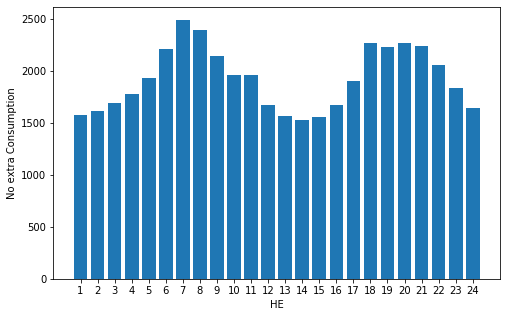

In [33]:
# Plot consumption without extra usage by hours
noextra = dfhour['total_consumption'] - df2hour['Extra']
plt.figure(figsize=(8,5))
plt.bar(dfhour['HE'], noextra)
plt.xticks(np.arange(1, 25))
plt.xlabel('HE')
plt.ylabel('No extra Consumption')
plt.show()

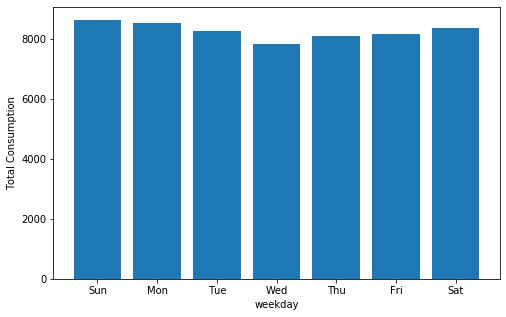

In [46]:
# Sum and plot usage by weekdays
dfweek = (dfnew >> group_by(X.weekday) >> summarize(total_consumption = X.total_consumption.sum()) 
          >> select(X.weekday, X.total_consumption))
weekday_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
dfweek['weekday'] = pd.Categorical(dfweek['weekday'], categories = weekday_order, ordered = True)
dfweek = dfweek.sort_values('weekday')
plt.figure(figsize=(8,5))
plt.bar(dfweek['weekday'], dfweek['total_consumption'])
plt.xlabel('weekday')
plt.ylabel('Total Consumption')
plt.show()

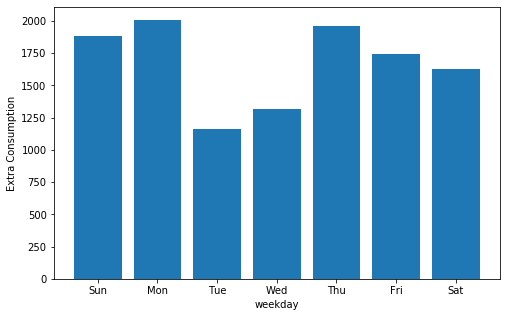

In [47]:
# Plot extra usage by weekdays
df2week =  (df2new >> group_by(X.weekday) >> summarize(Extra = X.Extra.sum()) >> select(X.weekday, X.Extra))
df2week['weekday'] = pd.Categorical(df2week['weekday'], categories = weekday_order, ordered = True)
df2week = df2week.sort_values('weekday')
plt.figure(figsize=(8,5))
plt.bar(df2week['weekday'], df2week['Extra'])
plt.xlabel('weekday')
plt.ylabel('Extra Consumption')
plt.show()

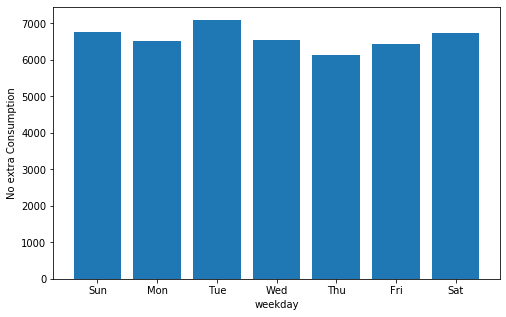

In [48]:
# Plot consumption without extra usage weekday
noextra = dfweek['total_consumption'] - df2week['Extra']
plt.figure(figsize=(8,5))
plt.bar(dfweek['weekday'], noextra)
plt.xlabel('weekday')
plt.ylabel('No extra Consumption')
plt.show()

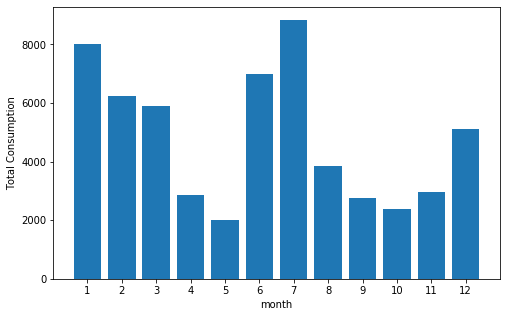

In [66]:
# Plot total usage by months
dfmonth = (dfnew >> group_by(X.month) >> summarize(total_consumption = X.total_consumption.sum()) 
          >> select(X.month, X.total_consumption))
plt.figure(figsize=(8,5))
plt.bar(dfmonth['month'], dfmonth['total_consumption'])
plt.xticks(np.arange(1, 13))
plt.xlabel('month')
plt.ylabel('Total Consumption')
plt.show()

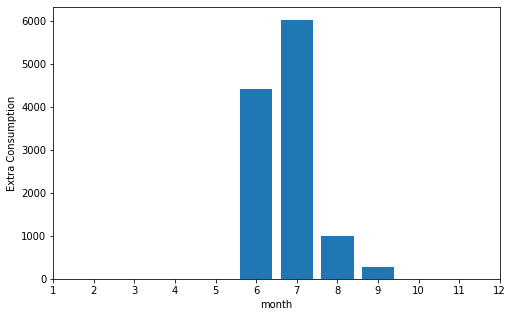

In [67]:
# Plot extra usage by months
df2month =  (df2new >> group_by(X.month) >> summarize(Extra = X.Extra.sum()) >> select(X.month, X.Extra))
plt.figure(figsize=(8,5))
plt.bar(df2month['month'], df2month['Extra'])
plt.xticks(np.arange(1, 13))
plt.xlabel('month')
plt.ylabel('Extra Consumption')
plt.show()

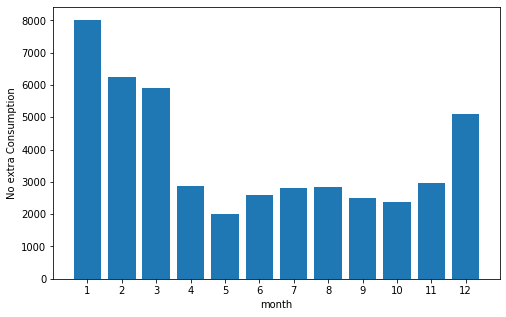

In [68]:
# Plot consumption without extra usage by months
dfmonth = (dfmonth >> left_join(df2month, by = 'month')).fillna(0)
noextra = dfmonth['total_consumption'] - dfmonth['Extra']
plt.figure(figsize=(8,5))
plt.bar(dfmonth['month'], noextra)
plt.xticks(np.arange(1, 13))
plt.xlabel('month')
plt.ylabel('No extra Consumption')
plt.show()